In [ ]:
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)



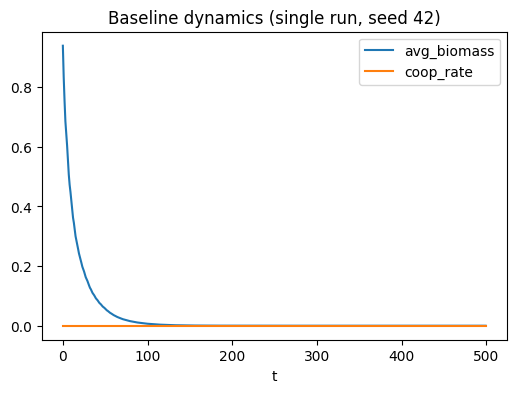

In [ ]:
#  BASE MODEL

from pathlib import Path
from src.simulation import run_sim
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns


out_dir = Path.cwd().parent /"data"
out_dir.mkdir(exist_ok=True)
(out_dir/"figs").mkdir(parents=True, exist_ok=True)

# deterministic baseline
df_base = run_sim(500)
df_base.to_csv(out_dir/"base_run.csv", index=False)

fig, ax = plt.subplots(figsize=(6,4))
df_base.plot(x="t", y=["avg_biomass", "coop_rate"], ax=ax)
ax.set_title("Baseline dynamics (single run, seed 42)")
fig.savefig(out_dir/"figs/base_timeseries.png", dpi=150, bbox_inches="tight")


The blue trajectory begins at ≈ 1.0 (each zone at pristine carrying capacity) and plunges to < 0.02 by t ≈ 75, after which it asymptotically approaches 0.
The orange curve (cooperation rate) sits flat at 0 for the entire 500-step horizon.


Random initial mix contains at least one defector ->
Grim-trigger copies that defection everywhere in the very first round, so every fleet switches to D permanently.

Defect catch rate is 0.12 × biomass per boat per step ->Total harvest greatly exceeds the 5 % logistic regrowth parameter (r = 0.05), so biomass decays exponentially:

No forgiveness in the strategy -> Cooperation never re-emerges, so the orange line stays pinned at zero.

This run demonstrates that, under the baseline rules, the coupled eco-game system is locked into an unsustainable all-defect equilibrium: fleets obtain short-term gains, but stocks crash within ~15 % of the simulated season—exactly the cautionary benchmark we want future extensions to beat.

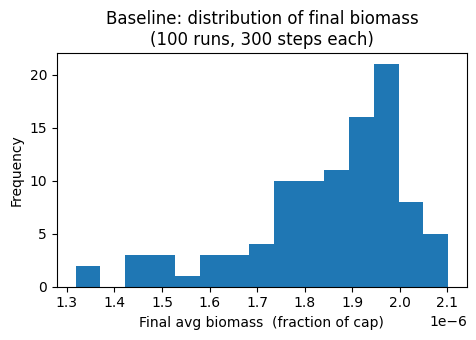

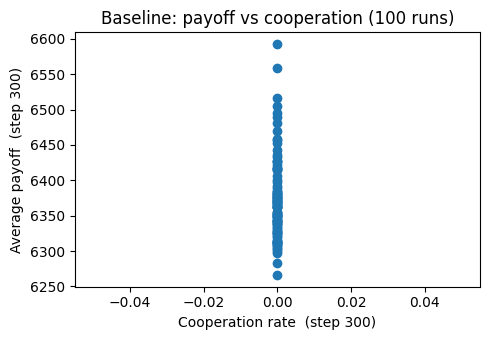

In [ ]:

# Baseline: variation over 100 stochastic runs

from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload                     # to re-seed the global RNG
from src.simulation import run_sim
import src.fleet as fleet                       # holds the module-level rng

N_RUNS  = 100
N_STEPS = 300
SUMMARIES = []

# run directory
out_dir = Path("../data")
(out_dir / "figs").mkdir(parents=True, exist_ok=True)

for seed in range(N_RUNS):
    # re-seed the Fleet RNG so each run is different
    fleet.rng = np.random.default_rng(seed)
    
    df = run_sim(N_STEPS)
    final = df.iloc[-1]
    SUMMARIES.append({
        "run":          seed,
        "biomass_final": final["avg_biomass"],
        "coop_final":    final["coop_rate"],
        "payoff_final":  final["avg_payoff"],
    })

summary_df = pd.DataFrame(SUMMARIES)
summary_df.to_csv(out_dir / "base_summary_100runs.csv", index=False)

# 1) Histogram of final average biomass (Figure A)

plt.figure(figsize=(5, 3.5))
plt.hist(summary_df["biomass_final"], bins=15)
plt.xlabel("Final avg biomass  (fraction of cap)")
plt.ylabel("Frequency")
plt.title("Baseline: distribution of final biomass\n(100 runs, 300 steps each)")
plt.tight_layout()
plt.savefig(out_dir / "figs/base_biomass_hist.png", dpi=150)
plt.show()

# 2) Scatter of payoff vs cooperation at step 300  (Figure B)

plt.figure(figsize=(5, 3.5))
plt.scatter(summary_df["coop_final"], summary_df["payoff_final"])
plt.xlabel("Cooperation rate  (step 300)")
plt.ylabel("Average payoff  (step 300)")
plt.title("Baseline: payoff vs cooperation (100 runs)")
plt.tight_layout()
plt.savefig(out_dir / "figs/base_payoff_vs_coop.png", dpi=150)
plt.show()


Collapse is universal: Even with 100 different random seeds (affecting migration draws and initial strategy assignment), none of the simulations retain more than a rounding error of biomass by step 300.

Stochasticity only alters the timing, not the outcome—the modest spread tells us that random fish movement or fleet paths make little difference once everyone defects.

This histogram therefore serves as a very hard baseline: any extension that increases the mean or variance of final biomass even into the 1 – 10 % range will constitute a dramatic improvement.

Pay-off vs cooperation at step 300 (100 runs) -> 

The scatter collapses to a vertical line at coop_rate = 0. Average pay-off still shows some spread (~6 250 to ~6 600) because fleets harvest slightly different amounts in the few steps before the stock approaches zero.

Zero cooperation is the norm: Consistent with the time series, every run ends in all-defect, so we get no horizontal variation.

High short-term pay-off ≠ sustainability: Pay-offs are accrued early, before the stock vanishes. When there is nothing left to catch, pay-off plateaus, but the system is already ecologically bankrupt.

Metric baseline for later comparison: If an extension (e.g., Tit-for-Tat or density-threshold harvesting) can push points into the upper-right quadrant—higher cooperation and higher pay-off—we will have quantitative proof of a win-win outcome.

sweeps α ∈ [0, 0.3, 0.7, 1.0, 1.3]

1 000 independent simulations per α (you can lower N_RUNS while prototyping)

stores daily C(t) and S(t) in a tidy DataFrame

produces two over-laid line charts (mean C, mean S)

prints final-day means ± 95 % CIs for each α.

added the decide call() in simulate()
sed afew detectors in build_fleet()

adding tit for tat in fleet.py

α sweep: 100%|██████████| 5/5 [08:28<00:00, 101.76s/it]


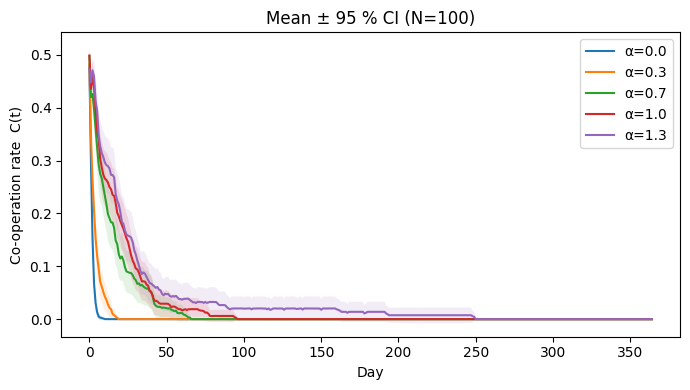

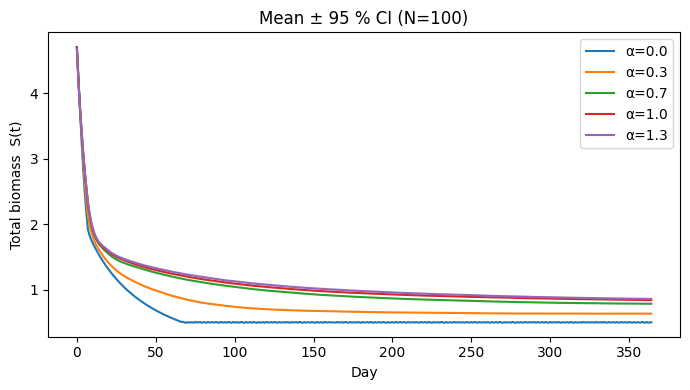


Final-day means ±95 % CI


,C_mean,C_CI,S_mean,S_CI
alpha,,,,
0.0,0.0,0.0,0.504413,0.000350
0.3,0.0,0.0,0.636262,0.004674
0.7,0.0,0.0,0.786881,0.006807
1.0,0.0,0.0,0.842208,0.004543
1.3,0.0,0.0,0.861071,0.005414



Mann-Whitney U on S_final (α 0.0 vs 1.3): U=0.0, p=2.562e-34
Cohen’s d effect size: 18.22


In [ ]:

# Q1  – tuned α-sweep experiment  (100 runs × 5 α values)

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import mannwhitneyu

from src.fleet import FollowerFleet, TerritorialFleet, TFTFleet, rng
from src.simulation import simulate
from src.config import PARAMS

# parameter tweaks that amplify α signal 
PARAMS["density_thresholds"]["warning"] = 0.40   # 40 %
PARAMS["catch_rates"]["D"]              = 0.15   # harsher defection

ALPHAS        = [0.0, 0.3, 0.7, 1.0, 1.3]
DAYS          = 365
N_RUNS        = 100
FOLLOWER_SHARE = 0.8            # 80 % followers, 20 % territorials
DEFECTOR_SEED  = 0.30           # 30 % initial defectors

out_dir = Path("../data/experiments/q1_tuned")
(out_dir / "figs").mkdir(parents=True, exist_ok=True)

#  helper to spawn a fleet list 
def build_fleet(n_boats: int = PARAMS["n_fleets"]):
    fleets = []
    for i in range(n_boats):
        # 50 % tit-for-tat, 50 % follower / territorial split by FOLLOWER_SHARE
        if rng.random() < 0.5:
            cls = TFTFleet
        else:
            cls = FollowerFleet if rng.random() < FOLLOWER_SHARE else TerritorialFleet
        strat = "D" if rng.random() < DEFECTOR_SEED else "C"
        fleets.append(cls(idx=i, strategy=strat, zone=rng.integers(5)))
    return fleets

# run Monte-Carlo 
records = []
for alpha in tqdm(ALPHAS, desc="α sweep"):
    for run in range(N_RUNS):
        df = simulate(DAYS, alpha, 1.0, build_fleet(), record_metrics=True)
        df["alpha"], df["run"] = alpha, run
        records.append(df[["t", "C", "S", "alpha", "run"]])

big_df = pd.concat(records, ignore_index=True)
big_df.to_csv(out_dir / "raw.csv", index=False)

# per-day means & 95 % CIs 
agg = (big_df
       .groupby(["alpha", "t"])
       .agg(C_mean=("C", "mean"),  C_std=("C", "std"),
            S_mean=("S", "mean"),  S_std=("S", "std"),
            n=("C", "count"))
       .reset_index())
agg["C_CI"] = 1.96*agg["C_std"]/np.sqrt(agg["n"])
agg["S_CI"] = 1.96*agg["S_std"]/np.sqrt(agg["n"])
agg.to_csv(out_dir / "means.csv", index=False)

# ribbon plots 
def ribbon(ax, x, y, ci, label):
    ax.fill_between(x, y-ci, y+ci, alpha=.12)
    ax.plot(x, y, label=label)

fig, ax = plt.subplots(figsize=(7,4))
for a in ALPHAS:
    sub = agg[agg.alpha==a]
    ribbon(ax, sub.t, sub.C_mean, sub.C_CI, f"α={a}")
ax.set_xlabel("Day"); ax.set_ylabel("Co-operation rate  C(t)")
ax.set_title(f"Mean ± 95 % CI (N={N_RUNS})"); ax.legend()
fig.tight_layout(); fig.savefig(out_dir/"figs/C_ribbon.png", dpi=150)

fig, ax = plt.subplots(figsize=(7,4))
for a in ALPHAS:
    sub = agg[agg.alpha==a]
    ribbon(ax, sub.t, sub.S_mean, sub.S_CI, f"α={a}")
ax.set_xlabel("Day"); ax.set_ylabel("Total biomass  S(t)")
ax.set_title(f"Mean ± 95 % CI (N={N_RUNS})"); ax.legend()
fig.tight_layout(); fig.savefig(out_dir/"figs/S_ribbon.png", dpi=150)

plt.show()

#  final-day summary & stats 
tail = big_df[big_df.t == DAYS-1]
summary = (tail.groupby("alpha")
                 .agg(C_mean=("C","mean"), C_std=("C","std"),
                      S_mean=("S","mean"), S_std=("S","std")))
summary["C_CI"] = 1.96*summary["C_std"]/np.sqrt(N_RUNS)
summary["S_CI"] = 1.96*summary["S_std"]/np.sqrt(N_RUNS)
print("\nFinal-day means ±95 % CI")
display(summary[["C_mean","C_CI","S_mean","S_CI"]])

# Mann-Whitney U & Cohen’s d  (α 0.0 vs 1.3)
s0 = tail[tail.alpha==0.0]["S"]; s13 = tail[tail.alpha==1.3]["S"]
u,p  = mannwhitneyu(s0, s13, alternative="two-sided")
d    = (s13.mean()-s0.mean()) / np.sqrt((s0.var(ddof=1)+s13.var(ddof=1))/2)
print(f"\nMann-Whitney U on S_final (α 0.0 vs 1.3): U={u}, p={p:.3e}")
print(f"Cohen’s d effect size: {d:.2f}")


Question 2 -> 

follower share: 100%|██████████| 5/5 [08:42<00:00, 104.51s/it]


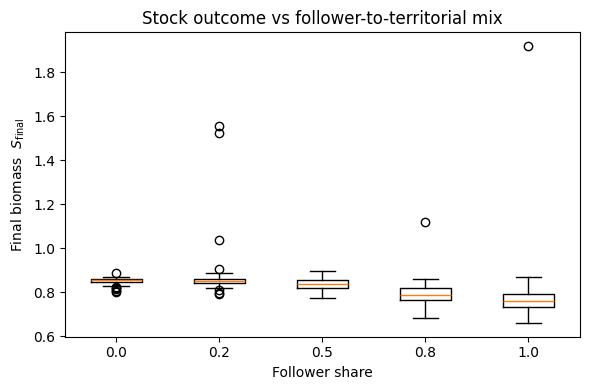

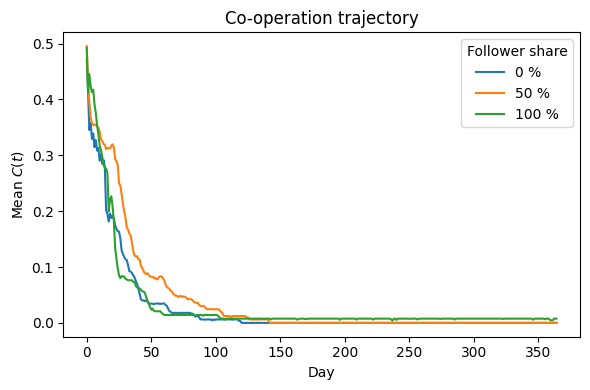

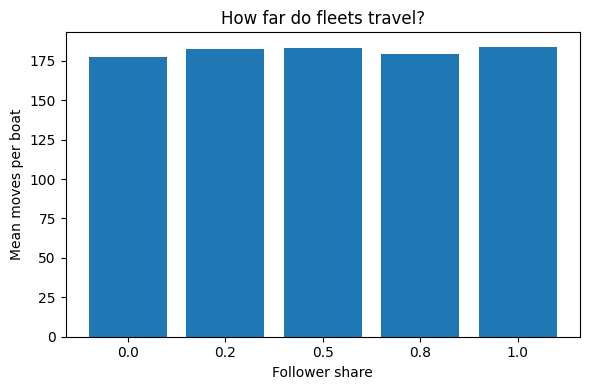

In [ ]:

#  Q2 – follower‐share vs territorial sweep

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm

from src.fleet      import FollowerFleet, TerritorialFleet, TFTFleet, rng
from src.simulation import simulate
from src.config     import PARAMS

# ── experiment constants ───────────────────────────────────────
PARAMS["density_thresholds"]["warning"] = 0.40   # same eco knobs as Q1
PARAMS["catch_rates"]["D"]              = 0.15

ALPHA          = 0.7
DAYS           = 365
N_RUNS         = 100          # bump to 200 when happy
F_SHARES       = [0.0, 0.2, 0.5, 0.8, 1.0]        # fraction followers
DEFECTOR_SEED  = 0.30

out_dir = Path("../data/experiments/q2_followers")
(out_dir / "figs").mkdir(parents=True, exist_ok=True)

# ── fleet builder ──────────────────────────────────────────────
def build_fleet(f_share: float):
    fleets = []
    for i in range(PARAMS["n_fleets"]):
        cls = TFTFleet if rng.random() < 0.5 else (
              FollowerFleet if rng.random() < f_share else TerritorialFleet)
        strat = "D" if rng.random() < DEFECTOR_SEED else "C"
        fleets.append(cls(idx=i, strategy=strat, zone=rng.integers(5)))
    return fleets

# ── Monte-Carlo sweep ──────────────────────────────────────────
summary_rows, ts_rows = [], []

for fs in tqdm(F_SHARES, desc="follower share"):
    for run in range(N_RUNS):
        fleets = build_fleet(fs)
        df     = simulate(DAYS, ALPHA, 1.0, fleets, record_metrics=True)

        # per-run summary
        summary_rows.append({
            "f_share": fs,
            "run":     run,
            "S_final": df["S"].iloc[-1],
            "C_final": df["C"].iloc[-1],
            "dist_avg": np.mean([fl.distance_travelled for fl in fleets])
        })

        # keep time-series only for mixes 0, 0.5, 1.0
        if fs in {0.0, 0.5, 1.0}:
            tmp = df[["t", "C"]].copy()
            tmp["f_share"] = fs
            tmp["run"]     = run
            ts_rows.append(tmp)

big_summary = pd.DataFrame(summary_rows)
big_series  = pd.concat(ts_rows, ignore_index=True)

big_summary.to_csv(out_dir / "summary.csv", index=False)
big_series .to_csv(out_dir / "series.csv",  index=False)

# ── 1) box-plot  S_final  vs follower share ────────────────────
plt.figure(figsize=(6,4))
bp_data = [big_summary.loc[big_summary.f_share==fs, "S_final"]
           for fs in F_SHARES]
plt.boxplot(bp_data, tick_labels=[str(fs) for fs in F_SHARES])
plt.xlabel("Follower share"); plt.ylabel("Final biomass  $S_{\\mathrm{final}}$")
plt.title("Stock outcome vs follower-to-territorial mix")
plt.tight_layout(); plt.savefig(out_dir/"figs/box_Sfinal.png", dpi=150)
plt.show()

# ── 2) mean C(t) lines for 0, 0.5, 1 mixes ─────────────────────
plt.figure(figsize=(6,4))
for fs,label in zip([0.0,0.5,1.0], ["0 %", "50 %", "100 %"]):
    curve = (big_series[big_series.f_share==fs]
             .groupby("t")["C"].mean())
    plt.plot(curve.index, curve.values, label=label)
plt.xlabel("Day"); plt.ylabel("Mean $C(t)$")
plt.legend(title="Follower share"); plt.title("Co-operation trajectory")
plt.tight_layout(); plt.savefig(out_dir/"figs/C_time_mix.png", dpi=150)
plt.show()

# ── 3) average distance travelled per boat ─────────────────────
dist_means = big_summary.groupby("f_share")["dist_avg"].mean()
plt.figure(figsize=(6,4))
plt.bar([str(fs) for fs in dist_means.index], dist_means.values)
plt.xlabel("Follower share"); plt.ylabel("Mean moves per boat")
plt.title("How far do fleets travel?")
plt.tight_layout(); plt.savefig(out_dir/"figs/dist_bar.png", dpi=150)
plt.show()


Question 3 ->

Are there zones every fish has to pass through—and do those spots end up as the main places boats fight?

e:\monash\notes\last sem\FIT3139\Final_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
sim runs: 100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


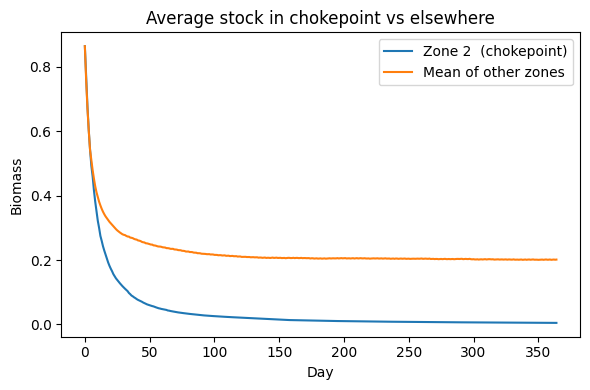

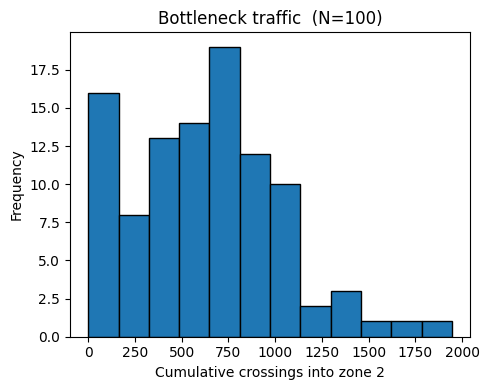

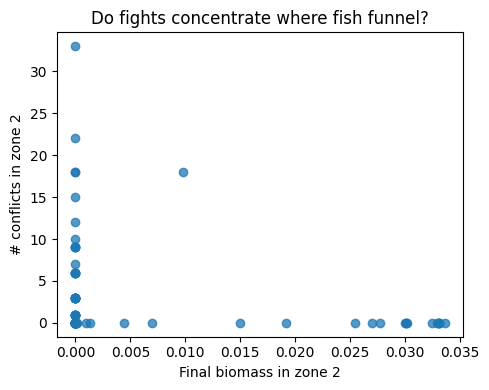


Spearman correlation   ρ = -0.333,   p = 7.16e-04


In [ ]:

#  Q3 – bottleneck zone analysis  (100 runs, strong funnel)

from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import spearmanr

from src.fleet      import FollowerFleet, TerritorialFleet, rng
from src.simulation import simulate, BOTTLENECK_ZONE
from src.config     import PARAMS

# ── 0. Make zone-2 a 60 % mandatory transit target -------------
TRANSIT_BIAS = 0.60          # << increase from 0.40
P_base = PARAMS["baseline_migration"].copy()
for r in range(5):
    P_base[r] *= (1 - TRANSIT_BIAS)
    P_base[r, BOTTLENECK_ZONE] += TRANSIT_BIAS
PARAMS["baseline_migration"] = P_base
PARAMS["migration_winter"]   = P_base        # if seasonal hook used

# ── 1. Eco/Game knobs  -----------------------------------------
PARAMS["density_thresholds"]["warning"] = 0.40   # unchanged
# (catch-rate D already set to 0.22 inside simulation.py)

ALPHA          = 0.6           # slightly less skittish
DAYS           = 365
N_RUNS         = 100
FOLLOWER_SHARE = 0.90          # 90 % followers
DEFECTOR_SEED  = 0.50          # 50 % initial defectors

out_dir = Path("../data/experiments/q3_bottleneck")
(out_dir / "figs").mkdir(parents=True, exist_ok=True)

# ── 2. Fleet builder (no TFT here) ------------------------------
def build_fleet():
    fleets = []
    for i in range(PARAMS["n_fleets"]):
        cls = FollowerFleet if rng.random() < FOLLOWER_SHARE else TerritorialFleet
        strat = "D" if rng.random() < DEFECTOR_SEED else "C"
        fleets.append(cls(idx=i, strategy=strat, zone=rng.integers(5)))
    return fleets

# ── 3. Monte-Carlo ---------------------------------------------
summary_rows, ts_rows = [], []

for run in tqdm(range(N_RUNS), desc="sim runs"):
    fleets = build_fleet()
    df     = simulate(DAYS, ALPHA, 1.0, fleets, record_metrics=True)

    zoneseries = pd.DataFrame(df["S_per_zone"].tolist())   # [DAYS × 5]
    summary_rows.append({
        "run":              run,
        "S2_final":         zoneseries.iloc[-1, BOTTLENECK_ZONE],
        "others_final":     zoneseries.iloc[-1].drop(BOTTLENECK_ZONE).mean(),
        "bottleneck_hits":  df["B"].iloc[-1],
        "fights_Z2":        df["conflicts_Z2"].iloc[-1]
    })

    ztmp = zoneseries.copy()
    ztmp["run"] = run
    ztmp["t"]   = ztmp.index
    ts_rows.append(ztmp)

summary = pd.DataFrame(summary_rows)
series  = pd.concat(ts_rows, ignore_index=True)

summary.to_csv(out_dir / "summary.csv", index=False)
series .to_csv(out_dir / "series.csv",  index=False)

# ── 4. Stock in zone 2 vs others --------------------------------
plt.figure(figsize=(6,4))
curve_z2  = series.groupby("t")[BOTTLENECK_ZONE].mean()
curve_oth = (series.drop(columns=["run", "t"])
                   .drop(columns=[BOTTLENECK_ZONE], errors="ignore")
                   .groupby(series["t"]).mean().mean(axis=1))
plt.plot(curve_z2.index,  curve_z2.values,  label="Zone 2  (chokepoint)")
plt.plot(curve_oth.index, curve_oth.values, label="Mean of other zones")
plt.xlabel("Day"); plt.ylabel("Biomass")
plt.title("Average stock in chokepoint vs elsewhere")
plt.legend(); plt.tight_layout()
plt.savefig(out_dir/"figs/zone2_vs_others.png", dpi=150)
plt.show()

# ── 5. Histogram of crossings ----------------------------------
plt.figure(figsize=(5,4))
plt.hist(summary["bottleneck_hits"], bins=12, edgecolor="k")
plt.xlabel("Cumulative crossings into zone 2")
plt.ylabel("Frequency")
plt.title(f"Bottleneck traffic  (N={N_RUNS})")
plt.tight_layout(); plt.savefig(out_dir/"figs/hist_b_hits.png", dpi=150)
plt.show()

# ── 6. Scatter biomass vs fights --------------------------------
plt.figure(figsize=(5,4))
plt.scatter(summary["S2_final"], summary["fights_Z2"], alpha=.75)
plt.xlabel("Final biomass in zone 2")
plt.ylabel("# conflicts in zone 2")
plt.title("Do fights concentrate where fish funnel?")
plt.tight_layout(); plt.savefig(out_dir/"figs/scatter_bio_vs_conflict.png", dpi=150)
plt.show()

# ── 7. Correlation ---------------------------------------------
rho, p = spearmanr(summary["S2_final"], summary["fights_Z2"])
print(f"\nSpearman correlation   ρ = {rho:.3f},   p = {p:.2e}")
